In [32]:
from __future__ import print_function
import sys
import os
import logging
import six
from radiomics import featureextractor, getFeatureClasses
import radiomics
%config Completer.use_jedi = False
import SimpleITK as sitk
import nibabel as nib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import logging
import cv2
import scipy.ndimage as nd

In [33]:
ls_image =sorted(glob.glob('./*_NAT*/*.nii'))

Tumeurs difficiles:
0,8,32,140
Chercher la plus grande composante connexe. Pénaliser un peu le rognage mais surtout pas trop!!

### Lire une image et afficher sa bonne slice

In [34]:
def slice_show(image_num):
    image_name = ls_image[image_num]
    image = sitk.ReadImage(image_name)
    print(image.GetSize())
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii') 
    mask = sitk.ReadImage(name_mask)
    print(mask.GetSize())
    n_slices = image.GetSize()[2]
    li_good = []
    for slice_num in range(n_slices):
        slice_try = image[:,:,slice_num]
        mask_slice_try = mask[:,:,slice_num]
        lsif = sitk.LabelStatisticsImageFilter()
        lsif.Execute(slice_try, mask_slice_try != 0)
        boundingBox = np.array(lsif.GetBoundingBox(label = 1))
        ndims = np.sum((boundingBox[1::2] - boundingBox[0::2] + 1) > 3)  # UBound - LBound + 1 = Size
        if (sitk.GetArrayFromImage(mask_slice_try != 0).sum() > 0) & (ndims >= 2):
            li_good.append(slice_num)
    if len(li_good) == 0:
        print('No good slices')
        return
    correct_slice = li_good[len(li_good)//2]
    slice_good = image[:,:,correct_slice]
    plt.figure(figsize = (15,5))
    plt.subplot(1, 2, 1)
    plt.imshow(sitk.GetArrayFromImage(slice_good))
    mask_slice_good = mask[:,:,correct_slice]
    plt.subplot(1, 2, 2)
    plt.imshow(sitk.GetArrayFromImage(mask_slice_good))
    print("slice_num:", correct_slice)

(512, 512, 100)
(512, 512, 100)
slice_num: 65


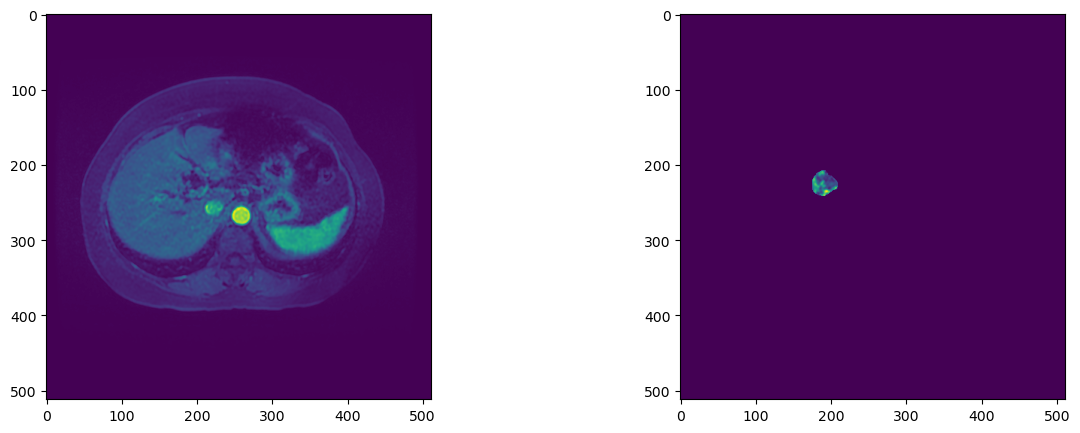

In [35]:
slice_show(4)

### Lire une image et afficher le mask par dessus

In [36]:
def rescale_image(image):
    # Normaliser les valeurs de l'image entre 0 et 1
    image_min = np.min(image)
    image_max = np.max(image)
    image_normalized = (image - image_min) / (image_max - image_min)
    
    # Redimensionner les valeurs normalisées entre 0 et 255
    image_rescaled = (image_normalized * 255).astype(np.uint8)
    
    return image_rescaled

def rescale_image_float(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)

In [37]:
def get_good_slice(image_name):
    image = sitk.ReadImage(image_name)
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii') 
    mask = sitk.ReadImage(name_mask)
    n_slices = image.GetSize()[2]
    li_good = []
    for slice_num in range(n_slices):
        slice_try = image[:,:,slice_num]
        mask_slice_try = mask[:,:,slice_num]
        lsif = sitk.LabelStatisticsImageFilter()
        lsif.Execute(slice_try, mask_slice_try != 0)
        boundingBox = np.array(lsif.GetBoundingBox(label = 1))
        ndims = np.sum((boundingBox[1::2] - boundingBox[0::2] + 1) > 3)  # UBound - LBound + 1 = Size
        if (sitk.GetArrayFromImage(mask_slice_try != 0).sum() > 0) & (ndims >= 2):
            li_good.append(slice_num)
    if len(li_good) == 0:
        print('No good slices')
        return
    else:
        return li_good[len(li_good)//2]

On peut même afficher un second masque en plus!

In [38]:
def mask_superpose(image_num, slice_num = None,other_mask = None):
    image_name = ls_image[image_num]
    image = sitk.ReadImage(image_name)
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii') 
    mask = sitk.ReadImage(name_mask)
    if slice_num is None:
        slice_num = get_good_slice(image_name)
    slice_good = sitk.GetArrayFromImage(image[:,:,slice_num])
    mask_slice_good = sitk.GetArrayFromImage(mask[:,:,slice_num]) !=0
    slice_rgb = rescale_image(np.stack([slice_good]*3, axis=-1))
    slice_rgb[:,:,0:3:2] = 0 #Seul canal 1 accepté
    slice_rgb[mask_slice_good == 1,0] = 255
    if other_mask is not None:
        mask_superpose = other_mask !=0
        slice_rgb[mask_superpose == 1,2] = 255
    plt.figure(figsize = (15,5))
    plt.subplot(1, 3, 1)
    plt.imshow(slice_rgb)
    plt.subplot(1, 3, 2)
    plt.imshow(slice_good)
    plt.subplot(1, 3, 3)
    plt.imshow(sitk.GetArrayFromImage(mask[:,:,slice_num]))


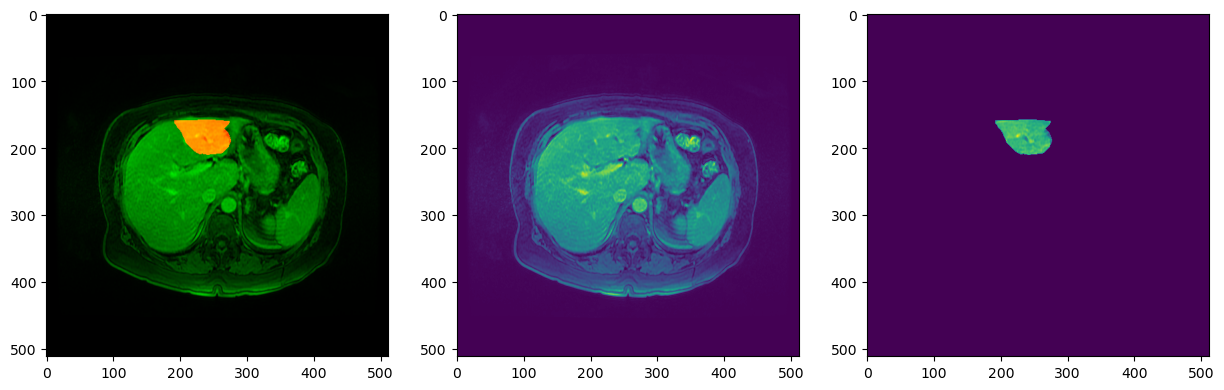

In [39]:
mask_superpose(25)

### Dilatation et érosion d'une image avec opencv

In [40]:
def cercle_image(image_num, slice_num = None,show = False):
    image_name = ls_image[image_num]
    image = sitk.ReadImage(image_name)
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii')
    mask = sitk.ReadImage(name_mask)
    if slice_num is None:
        slice_num = get_good_slice(image_name)
    slice_good = sitk.GetArrayFromImage(image[:,:,slice_num])
    mask_slice_good = sitk.GetArrayFromImage(mask[:,:,slice_num]) !=0
    mask_slice_good = mask_slice_good.astype(np.uint8)
    mask_dilation_first = cv2.dilate(mask_slice_good, np.ones((3,3), np.uint8), iterations = 8)
    mask_dilation_second = cv2.dilate(mask_slice_good, np.ones((3,3), np.uint8), iterations = 15)
    mask_cercle = mask_dilation_second - mask_dilation_first
    
    #histogramme sur variance locale
    
    filtered = rescale_image_float(slice_good).astype(np.float64)
    size = 5
    mean = nd.uniform_filter(filtered, size)
    mean_sq = nd.uniform_filter(filtered**2, size)
    variance = (mean_sq - mean**2)
    hist, bins = np.histogram(variance[mask_cercle == 1].flatten(), bins = "doane")
    
    #On a les bins maintenant on classe les points
    shape_init = slice_good.shape
    bin_indices = np.digitize(variance.flatten(), bins) - 1
    bin_indices = bin_indices.reshape(shape_init)
    bin_indices[mask_cercle == 0] = -1
    
    #On choisit les bins qu'on garde de l'histogramme: à côté les unes des autres
    pic = np.argmax(hist)
    pic = 0 ##################### ATTENTION C'est car on cherche le minimum de variance
    deja_pris = [pic]
    taille_max = np.sum(mask_cercle == 1)*0.1
    taille = hist[pic]
    nbins = len(hist)
    while taille < taille_max:
        possible = []
        if max(deja_pris) + 1< nbins :
            possible.append(max(deja_pris) + 1)
        if min(deja_pris) > 0:
            possible.append(min(deja_pris) - 1)
        values = [hist[i] for i in possible]
        new_bar = possible[np.argmax(values)]
        deja_pris.append(new_bar)
        taille = taille + hist[new_bar]
    
    bool_matrix = np.isin(bin_indices, deja_pris)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(bool_matrix)
    plt.subplot(1, 3, 2)
    plt.imshow(variance)
    plt.subplot(1, 3, 3)
    plt.hist(variance[mask_cercle == 1].flatten(), bins=bins, edgecolor='black')
    plt.title("Histogramme des valeurs des pixels")
    plt.xlabel("Valeur des pixels")
    plt.ylabel("Fréquence")
    plt.show()
    
    quantile_low_lum = np.quantile(slice_good.flatten(),0.05) #pas être dans le noir complet
    cercle_lumineux = bool_matrix & (slice_good > quantile_low_lum)
    
    
    # quantile_inf_cercle = np.quantile(slice_good[mask_cercle == 1].flatten(),0.5)
    # quantile_sup_tumeur = np.quantile(slice_good[mask_slice_good == 1].flatten(),0.7)
    # if quantile_inf_cercle < np.quantile(slice_good[mask_slice_good == 1].flatten(),0.3):
    #     cercle_lumineux = (slice_good > quantile_inf_cercle) & (mask_cercle == 1) & (slice_good < quantile_sup_tumeur)
        
    # else:
    #     cercle_lumineux = (mask_cercle == 1) & (slice_good > quantile_inf_cercle)
    cercle_lumineux = cercle_lumineux.astype(np.uint8)
    if show:
        mask_superpose(image_num, slice_num = slice_num, other_mask = mask_cercle)
        mask_superpose(image_num, slice_num = slice_num, other_mask = cercle_lumineux)
    return cercle_lumineux, slice_good, mask_slice_good, mask_cercle
    


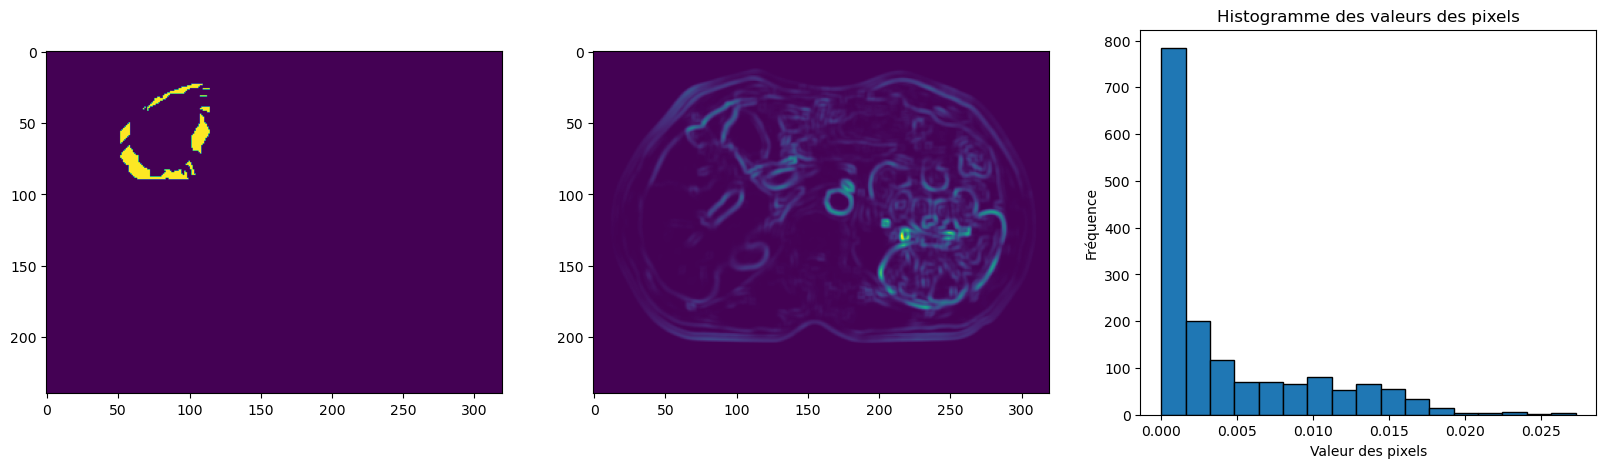

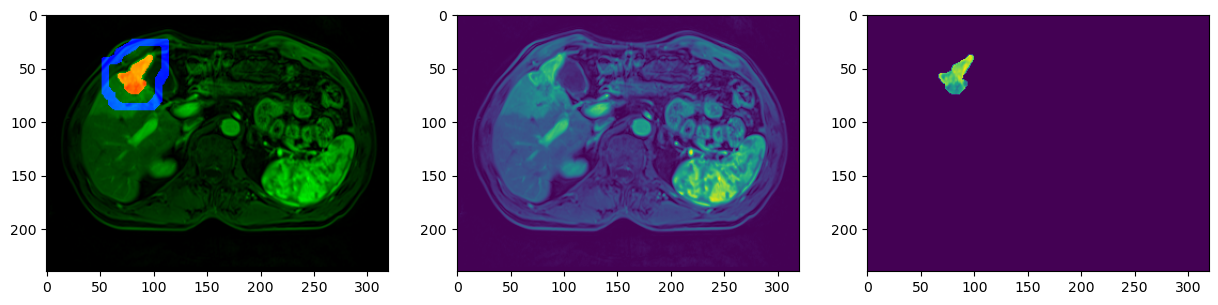

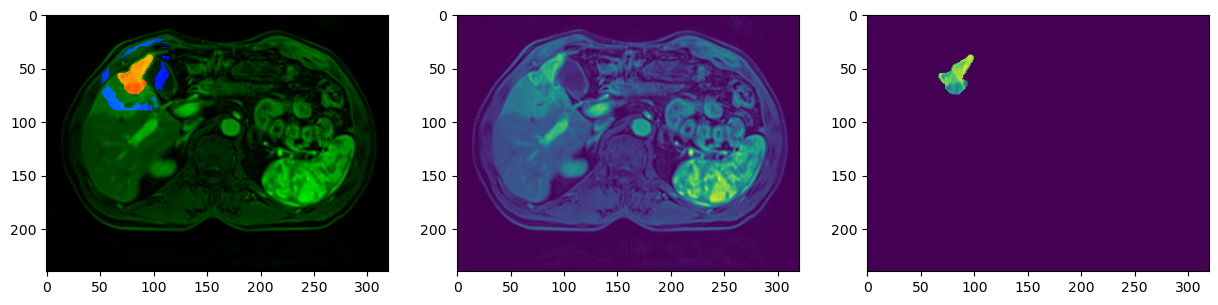

In [49]:
li = cercle_image(0, show = True)


numéros difficiles: 
[0,8,32]

### Avec des composantes connexes

In [42]:



def cercle_image_compos_connexe(image_num, slice_num = None,show = False):
    if slice_num is None:
        slice_num = get_good_slice(ls_image[image_num])
    mask_cercle_lumineux, slice_good, mask_slice_good, mask_cercle = cercle_image(image_num, slice_num= slice_num,show = False)
    components, num_comp = nd.label(mask_cercle_lumineux)
    dict_sizes = {str(i) :np.sum(components == i) for i in range(1, num_comp + 1)}
    dict_sizes = dict(sorted(dict_sizes.items(), key=lambda item: item[1], reverse = True))
    size_to_cover  = min(np.sum(mask_cercle) * 0.05, np.sum(mask_cercle_lumineux) * 0.5)
    covered_size = 0
    li_keys_compos_connexe = []
    i = 0
    while covered_size < size_to_cover:
        key = list(dict_sizes.keys())[i]
        li_keys_compos_connexe.append(key)
        covered_size += dict_sizes[key]
        i += 1
    mask_cercle_compos_connexe = np.zeros_like(mask_cercle_lumineux)
    for key in li_keys_compos_connexe:
        mask_cercle_compos_connexe += (components == int(key)).astype(np.uint8)
    if show:
        mask_superpose(image_num, slice_num = slice_num, other_mask = mask_cercle_lumineux)
        mask_superpose(image_num, slice_num = slice_num, other_mask = mask_cercle_compos_connexe)
    return mask_cercle_compos_connexe
    
        
    


71


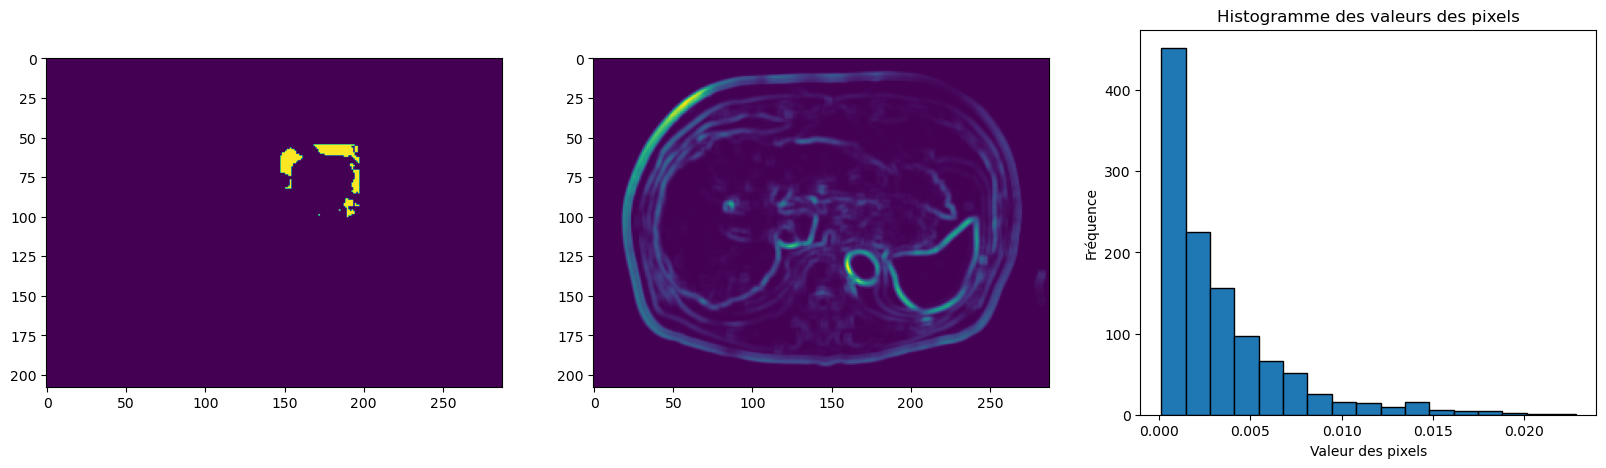

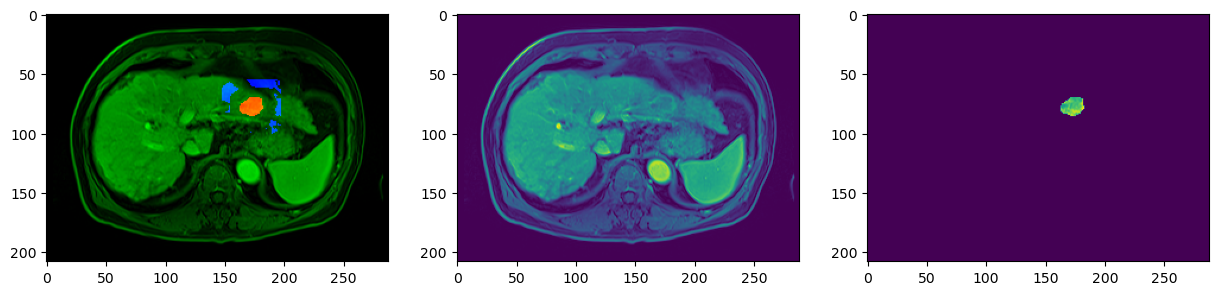

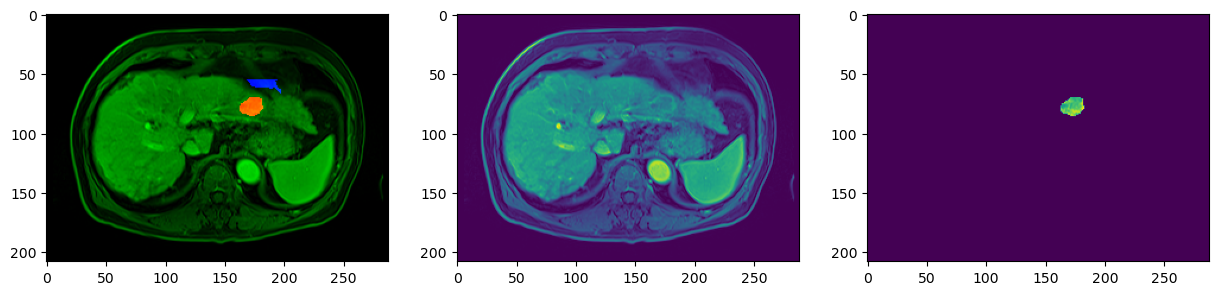

In [53]:
print(get_good_slice(ls_image[39]))
li = cercle_image_compos_connexe(200,show = True)

0.014407519809901738


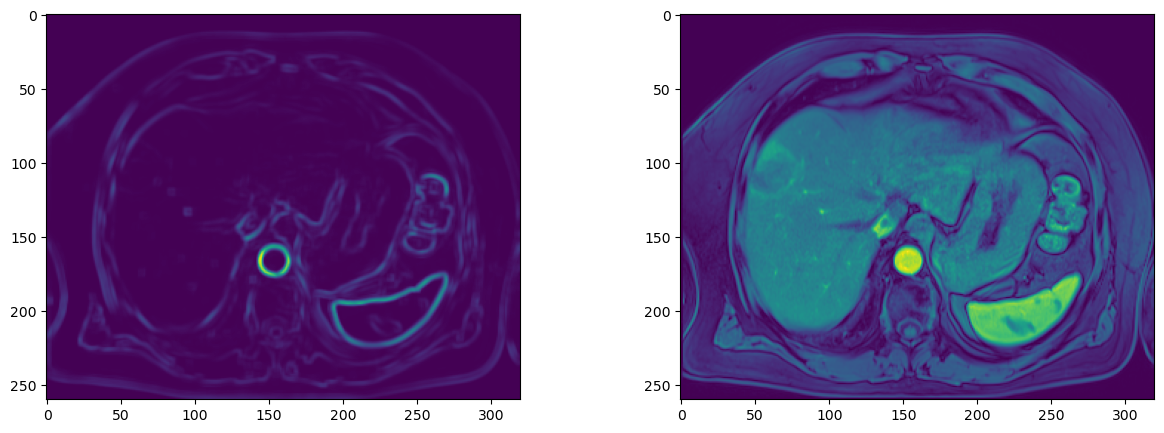

In [44]:
from scipy.fftpack import fft2, fftshift



image_num = 8
size = 5

slice_num = get_good_slice(ls_image[image_num])
image_name = ls_image[image_num]
image = sitk.ReadImage(image_name)
name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii')
mask = sitk.ReadImage(name_mask)
slice_good = sitk.GetArrayFromImage(image[:,:,slice_num])
filtered = rescale_image_float(slice_good).astype(np.float32)

mean = nd.uniform_filter(filtered, size)
mean_sq = nd.uniform_filter(filtered**2, size)
variance = (mean_sq - mean**2)
#variance = nd.uniform_filter((filtered - mean)**2, size)
print(np.quantile(variance,0.95))
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.imshow(variance)
plt.subplot(1, 2, 2)
plt.imshow(filtered)